In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import h5py
import matplotlib.pyplot as plt
device = torch.device('cpu')

In [74]:
## Take in the dataset and normalize / rearrange
class binary_data_norm(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images / 255.0, dtype=torch.float32)  # Normalize
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].permute(2, 0, 1)  # Rearrange dimensions
        label = self.labels[idx]
        return image, label

In [ ]:
## ConvNN adds two convolutional layers to learn features (large) for example cat
class ConvNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNN, self).__init__()
        # Two Conv layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=16, stride=2, padding=7)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=8, stride=2, padding=3)

        # Linear Layers
        self.fc1 = nn.Linear(16*16*16, 32) 
        self.fc2 = nn.Linear(32, num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # 64x64 -> 32x32
        x = self.relu(self.conv2(x))  # 32x32 -> 16x16
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [69]:
# Load HDF5 data
def load_h5_data(train_path, test_path):
    with h5py.File(train_path, 'r') as train_file:
        train_images = train_file['train_set_x'][()]
        train_labels = train_file['train_set_y'][()]
    
    with h5py.File(test_path, 'r') as test_file:
        test_images = test_file['test_set_x'][()]
        test_labels = test_file['test_set_y'][()]

    return train_images, train_labels, test_images, test_labels

In [ ]:
## Training loop, run for number of epochs and train NN
def train(model, train_loader, loss_func, optim, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optim.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optim.step()

            loss_sum += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_sum/len(train_loader):.4f}")

## Evaluation function: 
def evaluate_images(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    incorrect_indices = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            incorrect_indices.extend((predicted != labels).nonzero(as_tuple=True)[0].tolist())

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_indices

In [ ]:
# Load in data
train_path = 'train_catvnoncat.h5'
test_path = 'test_catvnoncat.h5'
train_images, train_labels, test_images, test_labels = load_h5_data(train_path, test_path)

# Prepare new datasets and dataloaders
def modify_dataset(train_images, train_labels, last_digit_of_id):
    new_train_size = 160 + last_digit_of_id
    new_train_images = train_images[:new_train_size]
    new_train_labels = train_labels[:new_train_size]
    new_test_images = train_images[new_train_size:]
    new_test_labels = train_labels[new_train_size:]
    return new_train_images, new_train_labels, new_test_images, new_test_labels

id_digit = 7
new_train_images, new_train_labels, new_test_images, new_test_labels = modify_dataset(train_images, train_labels, id_digit)
new_train_dataset = binary_data_norm(new_train_images, new_train_labels)
new_test_dataset = binary_data_norm(new_test_images, new_test_labels)
new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

# Model Initalization
model = ConvNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
train(model, new_train_loader, criterion, optimizer, num_epochs=1000)

# Evaluate the outputs
incorrect_indices = evaluate_images(model, new_test_loader)
# Print incorrect indices
print("Incorrect Indices:", incorrect_indices)

Epoch [1/1000], Loss: 0.6936
Epoch [2/1000], Loss: 0.6489
Epoch [3/1000], Loss: 0.7080
Epoch [4/1000], Loss: 0.6638
Epoch [5/1000], Loss: 0.6495
Epoch [6/1000], Loss: 0.6022
Epoch [7/1000], Loss: 0.6820
Epoch [8/1000], Loss: 0.6109
Epoch [9/1000], Loss: 0.6189
Epoch [10/1000], Loss: 0.6318
Epoch [11/1000], Loss: 0.5833
Epoch [12/1000], Loss: 0.5937
Epoch [13/1000], Loss: 0.6181
Epoch [14/1000], Loss: 0.7083
Epoch [15/1000], Loss: 0.6087
Epoch [16/1000], Loss: 0.5437
Epoch [17/1000], Loss: 0.5618
Epoch [18/1000], Loss: 0.5560
Epoch [19/1000], Loss: 0.5351
Epoch [20/1000], Loss: 0.4772
Epoch [21/1000], Loss: 0.5050
Epoch [22/1000], Loss: 0.4682
Epoch [23/1000], Loss: 0.4680
Epoch [24/1000], Loss: 0.4652
Epoch [25/1000], Loss: 0.4358
Epoch [26/1000], Loss: 0.4383
Epoch [27/1000], Loss: 0.3945
Epoch [28/1000], Loss: 0.4557
Epoch [29/1000], Loss: 0.4542
Epoch [30/1000], Loss: 0.4586
Epoch [31/1000], Loss: 0.4658
Epoch [32/1000], Loss: 0.4401
Epoch [33/1000], Loss: 0.4634
Epoch [34/1000], Lo

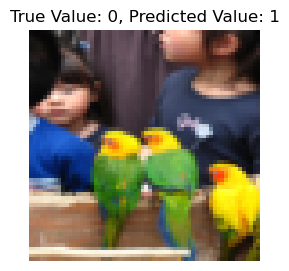

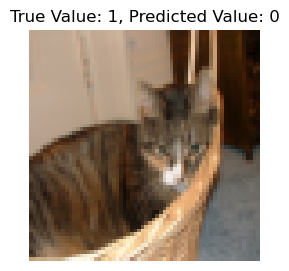

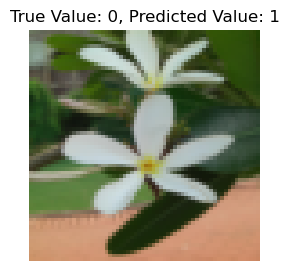

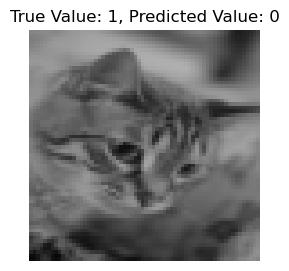

In [79]:
## Plotting loop (plots first 4 images)
for i, idx in enumerate(incorrect_indices[:4]):
    image, true_label = new_test_dataset[idx]
    image = image.to(device).contiguous().reshape(1, 3, 64, 64) # reshape to run model on 

    # run model on image
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)
    
    # reshape image
    image = image.contiguous().reshape(3, 64, 64).cpu().numpy().transpose(1, 2, 0)  # Reshape back to (H, W, C)
    
    # Plot and show
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(f"True Value: {true_label}, Predicted Value: {predicted_label.item()}")
    plt.axis('off')
    plt.show()